In [8]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

from glob import glob
import spacy
from collections import defaultdict
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk import tokenize

import seaborn as sns
sns.set_style("darkgrid")

from collections import Counter
import random

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import pickle
import gensim

In [2]:
data = pd.read_csv('case_metadata.csv')

In [190]:
data.head()

,caseid,case_reversed,judge_id,year,x_republican,log_cites
0,X3JGGO,0,1653.0,1925.0,1.0,1.098612
1,X3OH3J,0,1034.0,1924.0,0.0,1.609438
2,X3U0KO,0,2303.0,1925.0,0.0,1.791759
3,X53HAD,0,1764.0,1924.0,0.0,NaN
4,X9VC5V,0,493.0,1925.0,1.0,NaN


In [82]:
# normalize the corpus(i.e. remove punctuation)

fnames = glob('cases/*txt')
translator = str.maketrans('','',punctuation) 
stoplist = stopwords.words('english') 
stemmer = SnowballStemmer('english')
wnl = WordNetLemmatizer()

normalized_tokens = []

fnames_1 = fnames[:1000]

for fname in fnames_1:
    docid = fname.split('_')[-1][:-4]
    text = open(fname).read()
    
    # split on sentences
    sentences = tokenize.sent_tokenize(text)
    
    for text in sentences:
        # convert to lower case
        text_lower = text.lower()
        # remove punctuation
        text_nopunc = text_lower.translate(translator)
        # token
        tokens = text_nopunc.split()
        # remove numbers
        norm_numbers = [t for t in tokens if not t.isdigit()]
        # remove stopwords
        nostop = [t for t in norm_numbers if t not in stoplist]
        # stemming
        tokens_stemmed = [stemmer.stem(t) for t in nostop]
        # lemmatizing
        tokens_lemmatized = [wnl.lemmatize(t) for t in tokens_stemmed]
        normalized_tokens.append(tokens_lemmatized)

In [84]:
# save the corpus
#import pickle

#with open('corpus', 'wb') as fp:
#    pickle.dump(normalized_tokens, fp)

In [9]:
with open ('corpus', 'rb') as fp:
    normalized_tokens = pickle.load(fp)

### 1. Train a word embedding on your corpus, once with a small window (e.g. 2) and again with a long window (e.g. 16). What do you expect to change for the different window sizes? Pick a sample of 100 words and visualize them in two dimensions, to demonstrate the difference between the models.

Intuitively, larger window size will capture more topic information, i.e. what other words are used in related discussions. In contrast, smaller window size tend to capture more about the word itself, i.e. what are words are functionally similar.

In [98]:
model1 = Word2Vec(normalized_tokens, size=100, window=2,min_count=10,workers=8, sample=1e-3)
model1.train(normalized_tokens, total_examples=len(normalized_tokens), epochs=10)

model2 = Word2Vec(normalized_tokens, size=100, window=16,min_count=10,workers=8, sample=1e-3)
model2.train(normalized_tokens, total_examples=len(normalized_tokens), epochs=10)

(16174416, 17692300)

In [110]:
# sample 100 words from the corpus
corpus = []
for t in normalized_tokens:
    corpus.extend(t)
corpus_Counter = Counter(corpus)
corpus = [k for k, v in corpus_Counter.items() if v >= 10]
sample_words = random.sample(corpus, 100)

In [165]:
def tsnescatterplot(model, words):

    arrays = np.empty((100, 0), dtype='f')
    word_labels = []

    # adds the vector of each word
    for word in words:
        arrays = np.append(arrays, model.wv.__getitem__(word))
        word_labels.append(word)
    
    # Reduces the dimensionality to 50 dimensions with PCA
    arrays = arrays.reshape(-1,100)
    reduc = PCA(n_components=50).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(12, 12)
    
    # Basic plot
    p1 = sns.regplot(data=df, x="x", y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40}
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 weight='normal'
                ).set_size(10)

    
    plt.xlim(Y[:, 0].min()-2, Y[:, 0].max()+2)
    plt.ylim(Y[:, 1].min()-2, Y[:, 1].max()+2)
            
    plt.title('t-SNE visualization for 100 random words')

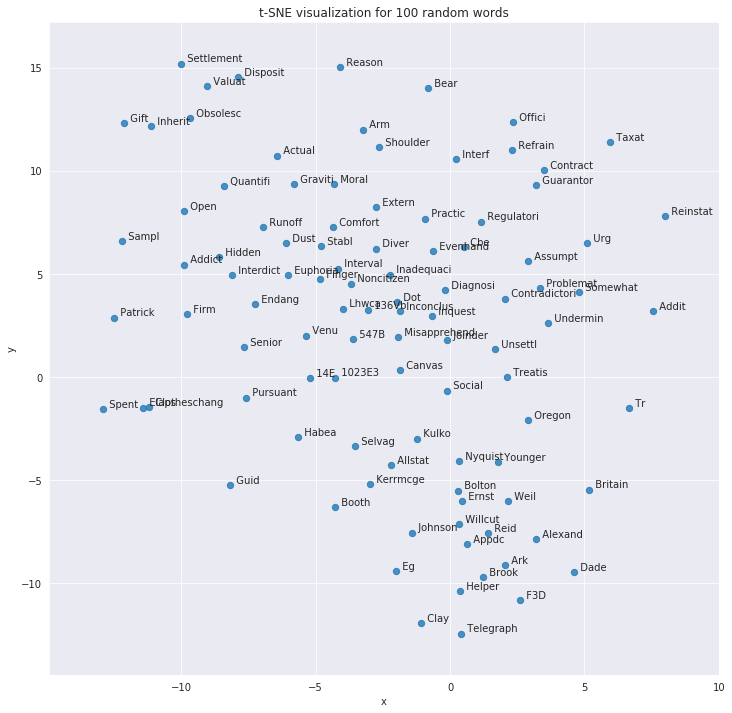

In [166]:
tsnescatterplot(model1, sample_words)

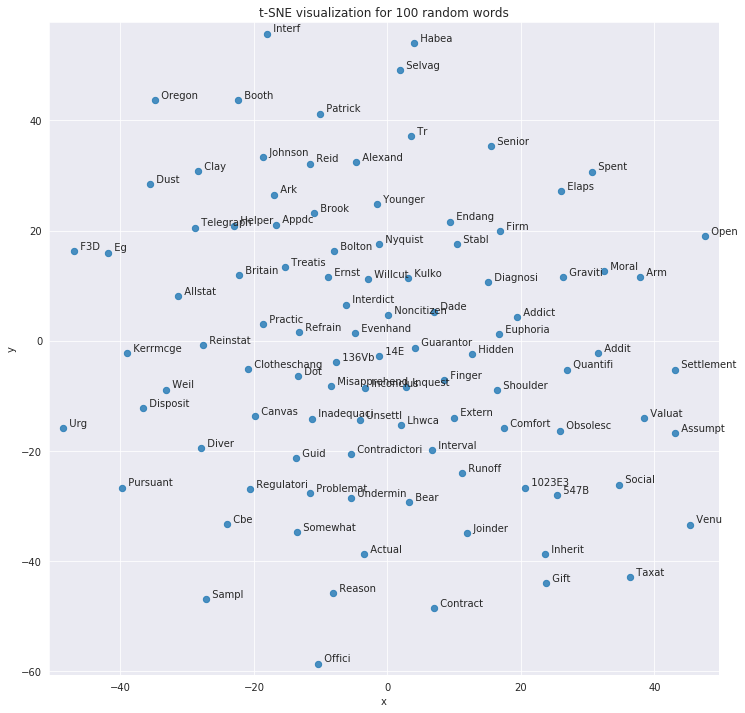

In [189]:
tsnescatterplot(model2, sample_words)

### 2. Train separate word embeddings for Republican and Democrat judges. Use your word embeddings to list the adjectives most associated with a social group or concept of your choice, and analyze differences by judge party.

I chose the keyword 'woman'.
For republicans judges, the top adjectives associated are 'pregnant, bodily, diagnosed, spousal, ruptured, psychological, irreversible, inevitable, physical, mental'.
For democrat judges, the top adjectives associated are 'pregnant, severely, maternal, societal, structured, sexual, emotional.'
For both republicans and democrats, pregnancy and abortion seems to be an important topic.
As far as I could see, republican judges relate woman more to some medical and psychological terms. 

In [191]:
republican_cases = data.loc[data.x_republican == 1]['caseid'].tolist()

In [270]:
# create separate corpus for republican and democrat judges
repub_corpus = []
demo_corpus = []

for fname in fnames_1:
    docid = fname.split('_')[-1][:-4]
    
    text = open(fname).read()
    # split on sentences
    sentences = tokenize.sent_tokenize(text)
    for text in sentences:
        text_lower = text.lower()
        text_nopunc = text_lower.translate(translator)
        tokens = text_nopunc.split()
        norm_numbers = [t for t in tokens if not t.isdigit()]
        nostop = [t for t in norm_numbers if t not in stoplist]
        tokens_stemmed = [stemmer.stem(t) for t in nostop]
        tokens_lemmatized = [wnl.lemmatize(t) for t in tokens_stemmed]
        if docid in republican_cases:
            repub_corpus.append(tokens_lemmatized)
        else:
            demo_corpus.append(tokens_lemmatized)

In [210]:
model3 = Word2Vec(repub_corpus, size=100, window=16,min_count=10,workers=8, sample=1e-3)
model3.train(repub_corpus, total_examples=len(repub_corpus), epochs=10)

model4 = Word2Vec(demo_corpus, size=100, window=16,min_count=10,workers=8, sample=1e-3)
model4.train(demo_corpus, total_examples=len(demo_corpus), epochs=10)

(8583280, 9590160)

In [280]:
# republican
model3.wv.most_similar('woman', topn=50)

[('pregnant', 0.792845606803894),
 ('notify', 0.7902772426605225),
 ('abortion', 0.7785625457763672),
 ('patient', 0.7576780319213867),
 ('abortions', 0.7550206184387207),
 ('provider', 0.7443308234214783),
 ('physician', 0.7386474609375),
 ('physicians', 0.7320663928985596),
 ('diagnosed', 0.7277299761772156),
 ('hasten', 0.7226292490959167),
 ('bodily', 0.7119048833847046),
 ('suffering', 0.6990536451339722),
 ('medically', 0.6973578929901123),
 ('spousal', 0.6965112686157227),
 ('lifesupport', 0.6936663389205933),
 ('child', 0.6874127388000488),
 ('clinics', 0.6856749057769775),
 ('minors', 0.6821843385696411),
 ('ruptured', 0.6801121234893799),
 ('patients', 0.6797289848327637),
 ('fetus', 0.6765463352203369),
 ('doctors', 0.6741095185279846),
 ('infection', 0.6666845083236694),
 ('women', 0.6652268171310425),
 ('terminallyill', 0.6647186279296875),
 ('fear', 0.6558197736740112),
 ('illness', 0.6485278606414795),
 ('psychological', 0.6460237503051758),
 ('irreversible', 0.641893148

In [279]:
# democrat
model4.wv.most_similar('woman', topn=50)

[('pregnant', 0.7836683988571167),
 ('abortion', 0.7547141909599304),
 ('abortions', 0.7342977523803711),
 ('fetus', 0.7006145119667053),
 ('physician', 0.6972509622573853),
 ('severely', 0.657129168510437),
 ('maternal', 0.6295619010925293),
 ('womans', 0.6254138946533203),
 ('women', 0.6238300800323486),
 ('mother', 0.6093072295188904),
 ('doctor', 0.5925911664962769),
 ('counseling', 0.5892457962036133),
 ('teach', 0.5699661374092102),
 ('perform', 0.569655179977417),
 ('society', 0.5680702924728394),
 ('suicide', 0.5656747817993164),
 ('communicate', 0.5654985308647156),
 ('spouses', 0.5641652345657349),
 ('performs', 0.5639195442199707),
 ('skills', 0.5638871192932129),
 ('family', 0.5637801289558411),
 ('choose', 0.562785267829895),
 ('attend', 0.5578809380531311),
 ('families', 0.5508506298065186),
 ('visits', 0.5399141311645508),
 ('oppositesex', 0.5351381301879883),
 ('performing', 0.5338907837867737),
 ('married', 0.5319960713386536),
 ('societal', 0.5301706790924072),
 ('can

### 3.Implement one of the causal inference methods from Lecture 12 (choose one of the following options):

- Look at the effect of text features on citations or reversal (Fong and Grimmer 2016)


In [74]:
# read in the training set
translator = str.maketrans('','',punctuation) 
stoplist = stopwords.words('english') 
stemmer = SnowballStemmer('english')
wnl = WordNetLemmatizer()

def clean_document(doc):
    doc = doc.translate(translator)
    doc = [wnl.lemmatize(stemmer.stem(i)) for i in doc.lower().split() if i not in stoplist and len(i) < 10]
    return doc
doc_clean = [clean_document(open(fname).read()) for fname in  glob('cases/*txt')[:1000]]

In [77]:
# train the LDA model on the training set
dictionary = gensim.corpora.Dictionary(doc_clean)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in doc_clean]
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [78]:
# print the topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.009*"servic" + 0.007*"bank" + 0.006*"insur" + 0.005*"id" + 0.005*"board" + 0.004*"citi" + 0.004*"congress" + 0.004*"polici" + 0.004*"school" + 0.003*"tax"
Topic: 1 
Words: 0.007*"board" + 0.006*"juri" + 0.005*"id" + 0.005*"plan" + 0.005*"defend" + 0.004*"charg" + 0.004*"employe" + 0.004*"congress" + 0.003*"compani" + 0.003*"nation"
Topic: 2 
Words: 0.006*"compani" + 0.004*"tax" + 0.004*"id" + 0.004*"power" + 0.004*"rate" + 0.004*"stock" + 0.003*"board" + 0.003*"public" + 0.003*"inc" + 0.003*"congress"
Topic: 3 
Words: 0.005*"juri" + 0.004*"wit" + 0.004*"id" + 0.004*"testimoni" + 0.004*"congress" + 0.003*"attorney" + 0.003*"counsel" + 0.003*"defend" + 0.003*"process" + 0.003*"crimin"
Topic: 4 
Words: 0.007*"id" + 0.005*"union" + 0.004*"f3d" + 0.004*"public" + 0.004*"conduct" + 0.004*"congress" + 0.003*"juri" + 0.003*"defend" + 0.003*"articl" + 0.003*"school"
Topic: 5 
Words: 0.007*"juri" + 0.005*"charg" + 0.005*"marshal" + 0.005*"defend" + 0.004*"f3d" + 0.004*"id" + 0

In [79]:
# read in the test set
test = [clean_document(open(fname).read()) for fname in  glob('cases/*txt')[1000:2000]]

In [99]:
bow_test = [dictionary.doc2bow(doc) for doc in test]
doc_lda = lda_model[bow_test[0]]
doc_lda

[(3, 0.19322512), (4, 0.13377655), (5, 0.6725037)]

In [142]:
# use the model for the test set
df = pd.DataFrame(columns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
for bow in bow_test:
    topic_prob = {0: 0, 1: 0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
    doc_lda = lda_model[bow]
    for (topic, probability) in doc_lda:
        topic_prob[topic] = probability
    df = df.append(topic_prob, ignore_index=True)

In [144]:
# add Y(case reversed) to the dataframe
docids = []
for fname in fnames[:1000]:
    docid = fname.split('_')[-1][:-4]
    docids.append(docid)
    
case_reversed = []
for docid in docids:
    case_reversed.append(data[data.caseid == docid].case_reversed.values[0])
df['const'] = 1
df['case_reversed'] = case_reversed
df.columns = ['topic1','topic2','topic3','topic4','topic5','topic6','topic7','topic8','topic9','topic10', 'const', 'case_reversed']

In [145]:
df.head()

,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,const,case_reversed
0,0.00000,0.000000,0.000000,0.196056,0.131981,0.671478,0.000000,0.000000,0.000000,0.0,1,1
1,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.064805,0.931875,0.0,1,1
2,0.59957,0.248346,0.052523,0.000000,0.000000,0.000000,0.052931,0.000000,0.046101,0.0,1,1
3,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.965375,0.000000,0.0,1,1
4,0.00000,0.197390,0.226580,0.000000,0.000000,0.286887,0.057435,0.218333,0.012892,0.0,1,1


In [152]:
import statsmodels.api as sm
model = sm.OLS(df.iloc[:,11], df.iloc[:, 0:10]).fit()

In [154]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          case_reversed   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     174.3
Date:                Mon, 13 May 2019   Prob (F-statistic):          2.31e-210
Time:                        21:47:30   Log-Likelihood:                -681.86
No. Observations:                1000   AIC:                             1384.
Df Residuals:                     990   BIC:                             1433.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
topic1         0.5261      0.094      5.605      0.000       0.342       0.710
topic2         0.5342      0.097      5.481      0.000       0.343       0.726
topic3         0.6718      0.072      9.295      0.000       0.530       0.814
topic4         0.5014      0.065      7.745      0.000       0.374       0.628
topic5         0.7856      0.068     11.572      0.000       0.652       0.919
topic6         0.5504      0.072      7.671      0.000       0.410       0.691
topic7         0.6399      0.068      9.472      0.000       0.507       0.772
topic8         0.6777      0.052     13.016      0.000       0.575       0.780
topic9         0.6187      0.087      7.107      0.000       0.448       0.790
topic10        0.7694      0.071     10.907      0.000       0.631       0.908
==============================================================================
Omnibus:                     5266.980   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              160.512
Skew:                          -0.536   Prob(JB):                     1.40e-35
Kurtosis:                       1.356   Cond. No.                         2.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""